In [1]:
import numpy as np
import scanpy as sc

%matplotlib inline

In [2]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)
adata = adata[:, adata.var.highly_variable].copy()
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]
adata.write("data/lung_atlas.h5ad")

/home/williamhan/miniconda3/envs/bioinfo/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)


In [3]:
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import yaml
import os

if os.path.exists("data/lung_atlas.h5ad"):
    adata = sc.read("data/lung_atlas.h5ad")
sce.pp.harmony_integrate(adata=adata, 
                         key=['batch'],
                         basis='X_pca',
                         max_iter_harmony = 20,
                         theta = None,
                         lamb = None,
                         sigma = 0.1, 
                         nclust = None,
                         tau = 0,
                         block_size = 0.05, 
                         max_iter_kmeans = 20,
                         epsilon_cluster = 1e-5,
                         epsilon_harmony = 1e-4, 
                         adjusted_basis='X_harmony')
adata.write("data/lung_atlas.h5ad")

2025-07-18 11:07:02,033 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-07-18 11:07:03,484 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-18 11:07:03,557 - harmonypy - INFO - Iteration 1 of 20
2025-07-18 11:07:06,924 - harmonypy - INFO - Iteration 2 of 20
2025-07-18 11:07:10,314 - harmonypy - INFO - Iteration 3 of 20
2025-07-18 11:07:14,098 - harmonypy - INFO - Iteration 4 of 20
2025-07-18 11:07:17,556 - harmonypy - INFO - Iteration 5 of 20
2025-07-18 11:07:20,989 - harmonypy - INFO - Iteration 6 of 20
2025-07-18 11:07:24,408 - harmonypy - INFO - Iteration 7 of 20
2025-07-18 11:07:27,836 - harmonypy - INFO - Iteration 8 of 20
2025-07-18 11:07:31,273 - harmonypy - INFO - Converged after 8 iterations


这段要为scvi-tools新建一个环境来跑，否则容易冲突导致环境崩溃

In [3]:
import scvi, os
import scanpy as sc

if os.path.exists("data/lung_atlas.h5ad"):
    adata = sc.read("data/lung_atlas.h5ad")
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, gene_likelihood="nb", n_layers=2, n_latent=30)
vae.train()
adata.obsm["scVI"] = vae.get_latent_representation()
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)
lvae.train(max_epochs=20, n_samples_per_label=100)
adata.obsm["scANVI"] = lvae.get_latent_representation()
adata.write("data/lung_atlas.h5ad")

/home/williamhan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/williamhan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing th

Epoch 246/246: 100%|██████████| 246/246 [03:28<00:00,  1.18it/s, v_num=1, train_loss_step=512, train_loss_epoch=519]

`Trainer.fit` stopped: `max_epochs=246` reached.


Epoch 246/246: 100%|██████████| 246/246 [03:28<00:00,  1.18it/s, v_num=1, train_loss_step=512, train_loss_epoch=519]
INFO     Training for 20 epochs.                                                                                   


/home/williamhan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/williamhan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|██████████| 20/20 [00:36<00:00,  1.83s/it, v_num=1, train_loss_step=574, train_loss_epoch=499]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:36<00:00,  1.84s/it, v_num=1, train_loss_step=574, train_loss_epoch=499]


这一段要为scib_metrics新建一个环境来跑，否则https://github.com/YosefLab/scib-metrics/issues/219

In [1]:
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
import os 
import scanpy as sc

if os.path.exists("data/lung_atlas.h5ad"):
    adata = sc.read("data/lung_atlas.h5ad")
    
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    # bio_conservation_metrics=BioConservation(),
    # batch_correction_metrics=BatchCorrection(),
    embedding_obsm_keys=["X_pca", "X_harmony", "scVI", "scANVI"],
    n_jobs=6,
)
bm.benchmark()

/home/williamhan/miniconda3/envs/scib-metrics/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/williamhan/miniconda3/envs/scib-metrics/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)
Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]WARNING:2025-07-18 14:51:38,440:jax._src.xla_bridge:794: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/williamhan/miniconda3/envs/scib-metrics/lib/python3.12/site-pac

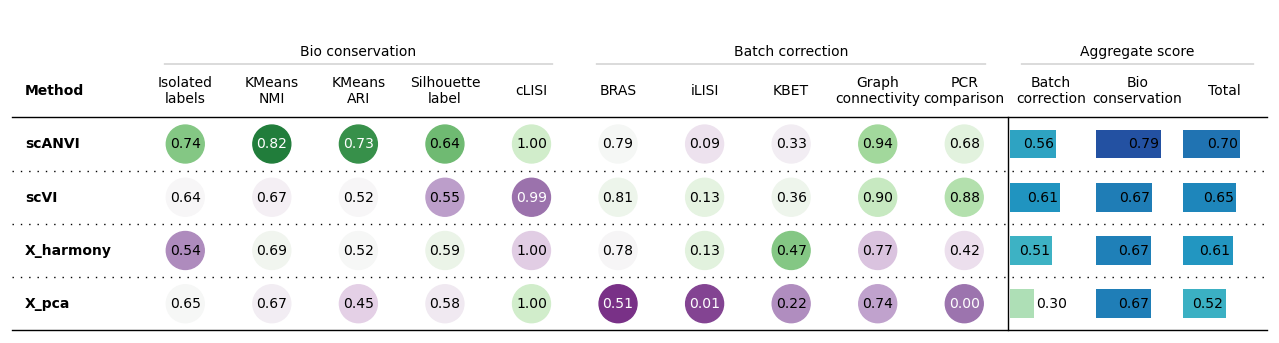

In [2]:
bm.plot_results_table()